In [28]:
import numpy as np
from osgeo import gdal
import os
import yaml
import geopandas as gpd
from shapely.geometry import box

with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

aridity_tif = resolve_path(config['Global_Aridity_Raster_path'])
print(aridity_tif)
ds = gdal.Open(aridity_tif)

projection = ds.GetProjection()
print(projection)

# Get the first raster band and read it as an array
band = ds.GetRasterBand(1)
print(band)
aridity_data = band.ReadAsArray()

# Get geotransform values and bounds
gt = ds.GetGeoTransform()
minx = gt[0]
maxy = gt[3]
maxx = minx + gt[1] * ds.RasterXSize
miny = maxy + gt[5] * ds.RasterYSize

# Define a bounding box for Africa
africa_minx, africa_miny = -18.0, -35.0  # approximate coordinates for Africa
africa_maxx, africa_maxy = 52.0, 38.0

# Calculate how much to trim (pixel offsets)
africa_min_col = int((africa_minx - minx) / gt[1])
africa_max_col = int((africa_maxx - minx) / gt[1])
africa_min_row = int((africa_maxy - maxy) / gt[5])
africa_max_row = int((africa_miny - maxy) / gt[5])

# Trim the data up to the Africa boundary
africa_data = aridity_data[africa_min_row:africa_max_row, africa_min_col:africa_max_col]

# Filter for aridity < 0.5 
filtered_africa_data = np.where(africa_data < 0.5, africa_data, np.nan)

# Create a new geotransform for the trimmed region
africa_gt = (
    minx + africa_min_col * gt[1],
    gt[1],
    0.0,
    maxy + africa_min_row * gt[5],
    0.0,
    gt[5]
)

# Save the filtered data as a tif file
output_tif = 'filtered_aridity_africa.tif' # Name the new file
driver = gdal.GetDriverByName('GTiff') # Get the driver for creating the GeoTIFF file
out_ds = driver.Create(output_tif, africa_max_col - africa_min_col, africa_max_row - africa_min_row, 1, gdal.GDT_Float32) # Params: name//width//height//# of bands//data type
out_ds.SetGeoTransform(africa_gt) # Set the geotransform for the new dataset
out_ds.SetProjection(ds.GetProjection()) # Make the new set uses the same coordinate system
out_band = out_ds.GetRasterBand(1) # Access the first band
out_band.WriteArray(filtered_africa_data) # Write the filtered aridity data to the new dataset
out_band.SetNoDataValue(np.nan) # Set no data value to NaN
out_ds = None # Close the file

import rasterio
from rasterio.features import shapes
import fiona

with rasterio.open(output_tif) as src:
    mask = src.dataset_mask() # Create a binary mask of the dataset
    shapes_generator = shapes(src.read(1), mask = mask, transform = src.transform) # Read the first band of the raster data, use the mask to identify valid areas, apply geotransformation

geoms = [shp for shp, val in shapes_generator if val < 0.5] # Filter generated shapes to include only those < 0.5
gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries.from_wkt([str(geom) for geom in geoms])) # Geometries -> GeoSeries -> GeoDataFrame
gdf.to_file(resolve_path(config['Africa_Arid_Regions_path']))

C:/Users/ermil/Documents/GitHub/Africa_Irrigation/Data/Raw/Global-AI_ET0_v3_annual/ai_v3_yr.tif
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x0000026D21A27600> >


MemoryError: Unable to allocate 561. MiB for an array with shape (8760, 8400) and data type float64

In [ ]:
from osgeo import gdal, osr
import numpy as np
import fiona
from fiona.crs import from_string
from shapely.geometry import shape, mapping
import rasterio
from rasterio.features import shapes
from affine import Affine

# Enable GDAL exceptions
gdal.UseExceptions()

# Read the global aridity index tif file
aridity_tif = resolve_path(config['Global_Aridity_Raster_path'])  # Replace with the path to your file
ds = gdal.Open(aridity_tif)
if ds is None:
    raise ValueError("Could not open the dataset. Please check the file path.")

# Get the projection
projection = ds.GetProjection()
print("Projection:", projection)

# Ensure the projection is in degrees
srs = osr.SpatialReference(wkt=projection)
if srs.IsGeographic():
    print("The coordinate system is geographic with units in degrees.")
else:
    print("The coordinate system is not geographic. Units may not be in degrees.")

band = ds.GetRasterBand(1)
aridity_data = band.ReadAsArray()

# Get geotransform and bounds
gt = ds.GetGeoTransform()
minx = gt[0]
maxy = gt[3]
maxx = minx + gt[1] * ds.RasterXSize
miny = maxy + gt[5] * ds.RasterYSize

# Define the bounding box for Africa (in degrees)
africa_minx, africa_miny = -18.0, -35.0  # approximate coordinates for Africa
africa_maxx, africa_maxy = 52.0, 38.0

# Calculate pixel offsets for the Africa bounding box
africa_min_col = int((africa_minx - minx) / gt[1])
africa_max_col = int((africa_maxx - minx) / gt[1])
africa_min_row = int((africa_maxy - maxy) / gt[5])
africa_max_row = int((africa_miny - maxy) / gt[5])

# Clip the data to Africa
africa_data = aridity_data[africa_min_row:africa_max_row, africa_min_col:africa_max_col]

# Filter the aridity data for values < 0.5
filtered_africa_data = np.where(africa_data < 0.5, africa_data, np.nan).astype(np.float32)

# Convert the geotransform to an Affine object
transform = Affine.translation(minx + africa_min_col * gt[1], maxy + africa_min_row * gt[5]) * Affine.scale(gt[1], gt[5])

shapes_generator = shapes(filtered_africa_data, mask=(~np.isnan(filtered_africa_data)), transform=transform)

# Define schema for the output shapefile
schema = {
    'geometry': 'Polygon',
    'properties': {'value': 'float'}
}

# Define the output shapefile path
output_shapefile = resolve_path(config['Africa_Arid_Regions_path'])  # You can specify a different path if needed

# Write shapes directly to a shapefile
with fiona.open(output_shapefile, 'w', driver='ESRI Shapefile', crs=from_string(projection), schema=schema) as shp:
    for geom, val in shapes_generator:
        if val < 0.5:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': val}
            })


Projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
The coordinate system is geographic with units in degrees.


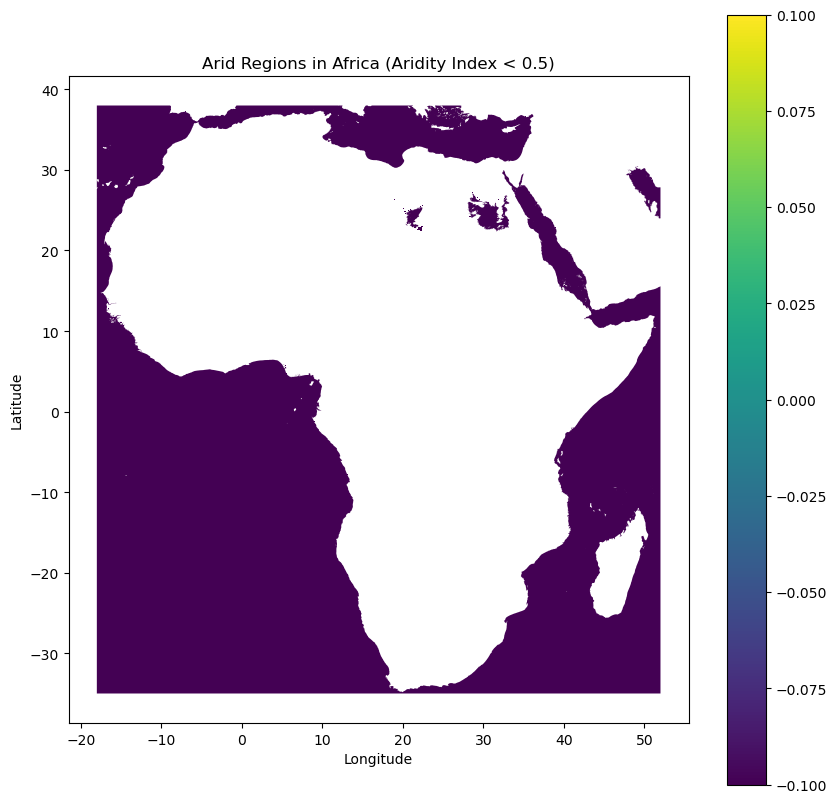

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Define the path to the shapefile
shapefile_path = resolve_path(config['Africa_Arid_Regions_path'])

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='value', cmap='viridis', legend=True)

# Set plot title and labels
ax.set_title('Arid Regions in Africa (Aridity Index < 0.5)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


In [ ]:
from osgeo import gdal, osr
import numpy as np

# Enable GDAL exceptions
gdal.UseExceptions()

# Read the global aridity index tif file
aridity_tif = resolve_path(config['Global_Aridity_Raster_path'])  # Replace with the path to your file
ds = gdal.Open(aridity_tif)
if ds is None:
    raise ValueError("Could not open the dataset. Please check the file path.")

# Get the projection
projection = ds.GetProjection()
print("Projection:", projection)

# Ensure the projection is in degrees
srs = osr.SpatialReference(wkt=projection)
if srs.IsGeographic():
    print("The coordinate system is geographic with units in degrees.")
else:
    print("The coordinate system is not geographic. Units may not be in degrees.")

band = ds.GetRasterBand(1)
aridity_data = band.ReadAsArray()

# Get geotransform and bounds
gt = ds.GetGeoTransform()
minx = gt[0]
maxy = gt[3]
maxx = minx + gt[1] * ds.RasterXSize
miny = maxy + gt[5] * ds.RasterYSize

# Define the bounding box for Africa (in degrees)
africa_minx, africa_miny = -18.0, -35.0  # approximate coordinates for Africa
africa_maxx, africa_maxy = 52.0, 38.0

# Calculate pixel offsets for the Africa bounding box
africa_min_col = int((africa_minx - minx) / gt[1])
africa_max_col = int((africa_maxx - minx) / gt[1])
africa_min_row = int((africa_maxy - maxy) / gt[5])
africa_max_row = int((africa_miny - maxy) / gt[5])

# Clip the data to Africa
africa_data = aridity_data[africa_min_row:africa_max_row, africa_min_col:africa_max_col]

# Print some values from the original TIF file
print("Some values from the original TIF file:")
print(aridity_data[:10, :10])  # Print the first 10x10 block of values

# Optionally, print unique values to inspect the range of data
print("Unique values from the original TIF file:")
print(np.unique(aridity_data))


# Print some values within the Africa bounding box
print("Some values within the Africa bounding box:")
print(africa_data[:10, :10])  # print the first 10x10 block of values

# Optionally, print unique values to inspect the range of data
print("Unique values within the Africa bounding box:")
print(np.unique(africa_data))


Projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
The coordinate system is geographic with units in degrees.
Some values from the original TIF file:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Unique values from the original TIF file:


MemoryError: Unable to allocate 890. MiB for an array with shape (933120000,) and data type bool